In [1]:
install.packages("remotes")
remotes::install_github("YuLab-SMU/aplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done




rlang        (1.1.1  -> 1.1.3 ) [CRAN]
lifecycle    (1.0.3  -> 1.0.4 ) [CRAN]
glue         (1.6.2  -> 1.7.0 ) [CRAN]
cli          (3.6.1  -> 3.6.2 ) [CRAN]
utf8         (1.2.3  -> 1.2.4 ) [CRAN]
fansi        (1.0.4  -> 1.0.6 ) [CRAN]
withr        (2.5.1  -> 3.0.0 ) [CRAN]
vctrs        (0.6.3  -> 0.6.5 ) [CRAN]
scales       (1.2.1  -> 1.3.0 ) [CRAN]
digest       (0.6.33 -> 0.6.34) [CRAN]
ggplot2      (3.4.3  -> 3.5.0 ) [CRAN]
yulab.utils  (NA     -> 0.1.4 ) [CRAN]
gridGraphics (NA     -> 0.5-1 ) [CRAN]
patchwork    (1.1.3  -> 1.2.0 ) [CRAN]
ggplotify    (NA     -> 0.1.2 ) [CRAN]
ggfun        (NA     -> 0.1.4 ) [CRAN]


Installing 16 packages: rlang, lifecycle, glue, cli, utf8, fansi, withr, vctrs, scales, digest, ggplot2, yulab.utils, gridGraphics, patchwork, ggplotify, ggfun

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



── R CMD build ─────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/RtmpzAElzx/remotes23d717bc622/YuLab-SMU-aplot-c66574a/DESCRIPTION’
─  preparing ‘aplot’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘aplot_0.2.2.tar.gz’
   


In [2]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))
library(parallel)
library(data.table)
library(cowplot)
library(ggsci)
library(aplot)
library(zip)

options(warn=-1)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots



Attaching package: ‘zip’


The following objects are masked from ‘package:utils’:

    unzip, zip




In [49]:
file_list<-list.files(path = paste0("/home/jupyter/formal_BRIanalysis/DEG_Mehul/DESeq2_Sex_yr1_Day_BR2"), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

## file_list

In [50]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [51]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [52]:
DEG<-DEG %>% filter(Year=='Y1')

In [53]:
DEG1 <- DEG %>% 
  mutate(Expression = case_when(
    log2FoldChange >= 0.1 & padj <= 0.1 ~ "Up-regulated-Male",
    log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated-Male",
    TRUE ~ "Unchanged"
  ))

In [54]:
DEG_filtered <- DEG1 %>% 
  filter(Expression != "Unchanged")

In [55]:
#df <- DEG
# Split the data frame based on 'celltype'
#list_dfs <- split(df, df$celltype)
# Loop through each split data frame
#for (celltype in names(list_dfs)) {
  # Order the data frame by 'padj'
#  ordered_df <- list_dfs[[celltype]] %>%
#                arrange(padj)
  # Create the file name
#  file_name <- paste("/home/jupyter/formal_BRIanalysis/DEG_Mehul/Sex_yr1_day0_deg_list/", 
#                     celltype, ".csv", sep = "")
  # Write to CSV
#  write.csv(ordered_df, file_name, row.names = FALSE)
#}

In [56]:
#zipfile <- "/home/jupyter/formal_BRIanalysis/DEG_Mehul/folder.zip"
#folder <- "/home/jupyter/formal_BRIanalysis/DEG_Mehul/Sex_yr1_day0_deg_list"
#zip(zipfile, files = folder)

In [57]:
freq <- aggregate(cbind(count = celltype) ~ celltype + Expression, data = DEG_filtered, FUN = length)

In [58]:
freq <- freq %>%
  mutate(count = ifelse(Expression == "Down-regulated-Male", -1 * count, count))

In [59]:
#ERROR PRONE. Couldn't figure out why
#freq <- DEG %>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated-D0",
#                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated-D0",
#                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
#  group_by(celltype, Expression) %>%
#  summarise(count = n())
#freq<-freq %>% mutate (count=case_when(Expression=="Down-regulated-D0"~-count,TRUE~count))

In [60]:
orders<-freq
orders$count<-abs(orders$count)
orders<-orders%>%
  group_by(celltype) %>%
  summarize(value = sum(count))%>%arrange(desc(value)) %>% select (celltype) %>% pull()

In [61]:
options(repr.plot.width = 10, repr.plot.height = 5)
#orders<-unique(freq %>% arrange(desc(count)) %>% select (celltype) %>% pull())
freq$celltype<-factor(freq$celltype,levels=orders)
p1<-ggplot(freq, aes(x = celltype, y = count, fill = Expression)) +
  geom_bar(stat = "identity", position = "identity") +theme_bw(base_size=12)+  scale_fill_aaas()+
  labs(x = "celltype", y = "DEG_Counts") +  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 15)) +
  guides(fill = guide_legend(reverse = TRUE))

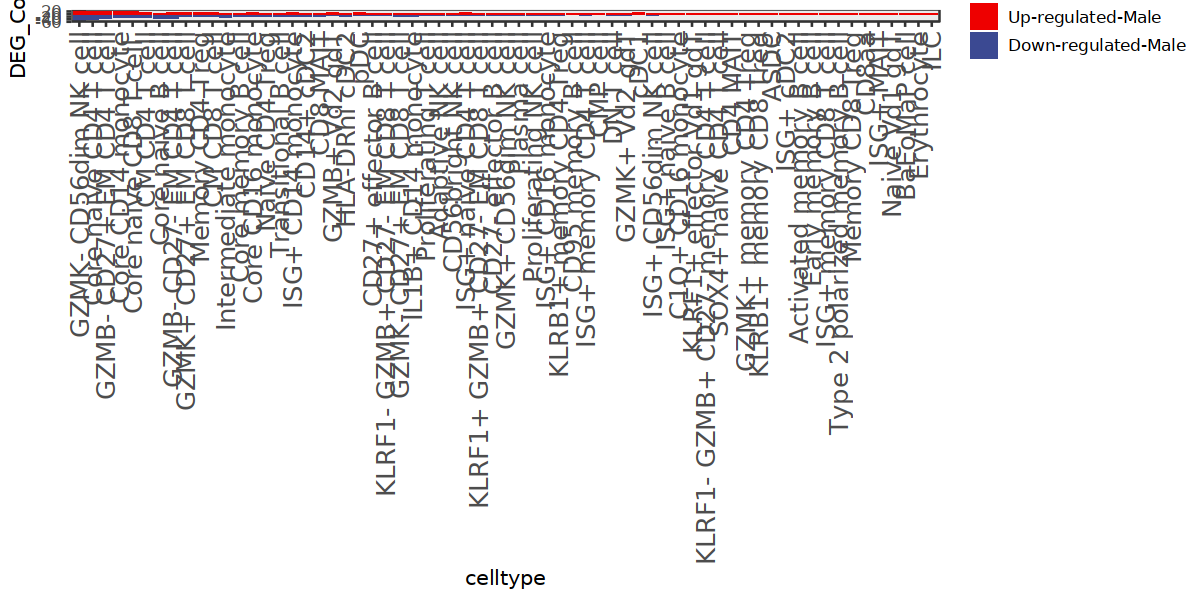

In [62]:
p1

In [63]:
total_gene <- DEG  %>%
  group_by(celltype) %>%
  summarise(count = n())
total_gene$celltype<-factor(total_gene$celltype,levels=orders)

In [64]:
p2<-ggplot(total_gene, aes(x = celltype, y = count)) +
  geom_bar(stat = "identity", position = "identity") +
  labs(x = "celltype", y = "Total_Genes_Expressed")+theme_bw(base_size=12)+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+ylab('N_Genes')

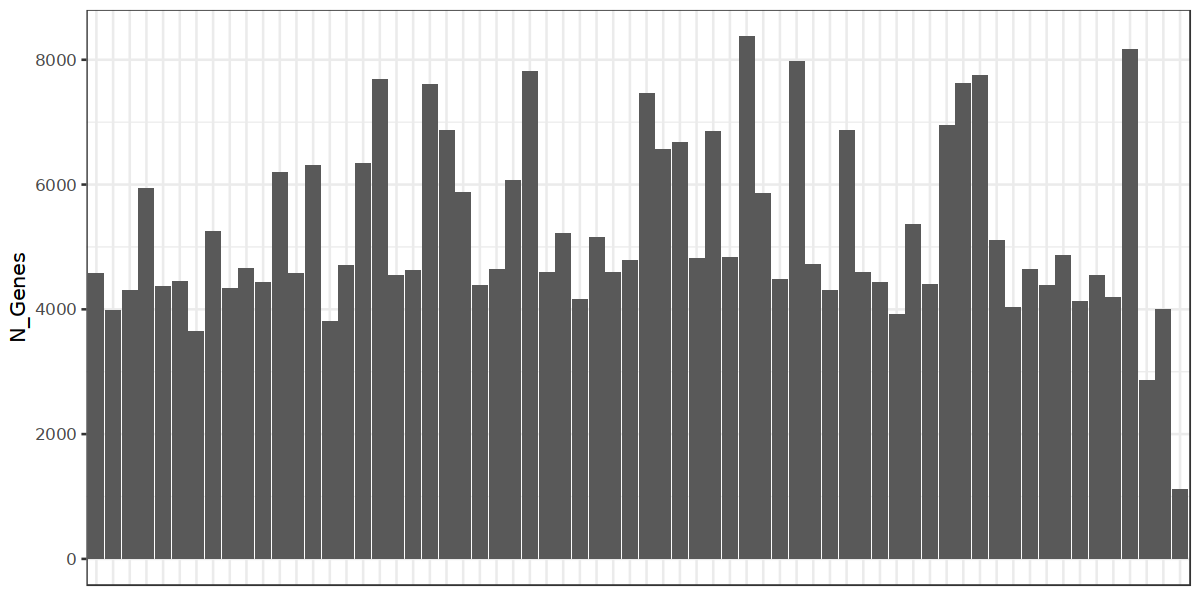

In [65]:
p2

In [66]:
#PNG
png("/home/jupyter/formal_BRIanalysis/DEG_Mehul/DEG_Sex_BR2_Day0.png", width = 1000, height = 500)

options(repr.plot.width = 24, repr.plot.height = 8)

p3<-p1 %>% insert_top(p2,height=0.7)

p3

dev.off()

png 
  2